# Simulacion de sistemas

Objetivos: 

1. Simular los sistemas de los ejercicios anteriores
2. Salvar esta simulacion como una imagen fits


In [1]:
# some standard python imports #
import numpy as np
import copy
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.image_util as image_util

In [3]:
def sim_img(beta_ra,beta_dec,phi,q,x1,x2,theta_E,deltaPix,numpix,fwhm_psf,exp_time,background_rms):
#lens model
    lens_model_list = ['SIE']
    lensModel = LensModel(lens_model_list=lens_model_list)
    e1,e2 = param_util.phi_q2_ellipticity(phi*np.pi/180.,q)
    kwargs_sie = {'theta_E': theta_E, 'e1':e1,'e2':e2,'center_x': x1, 'center_y': x2}
    kwargs_lens = [kwargs_sie]
#LightModel source:
    source_light_model_list = ['SERSIC']
    lightModel_source = LightModel(light_model_list=source_light_model_list)
    kwargs_light_source = [{'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]
#LightModel lens:
    lens_light_model_list = ['SERSIC_ELLIPSE']
    lightModel_lens = LightModel(light_model_list=lens_light_model_list)
    e1, e2 = param_util.phi_q2_ellipticity(phi=(phi+5)*np.pi/180., q=q)
    kwargs_light_lens = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': x1, 'center_y': x2}]
#Point Source
    point_source_model_list = ['LENSED_POSITION']
    pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[False])
    solver = LensEquationSolver(lensModel)
    theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)
    mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)
    kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': np.abs(mag)*100}]
#Data
    deltaPix = deltaPix  # tamano del pixel en cordenadas angulares (arcsec)
    numpix = numpix
# configurar los argumentos para crear la clase Data 
    ra_at_xy_0, dec_at_xy_0 = x1-(deltaPix)*(numpix/2.),x2-(deltaPix)*(numpix/2.) 
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
    kwargs_pixel = {'nx': numpix, 'ny': numpix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
    pixel_grid = PixelGrid(**kwargs_pixel)
# como revisar que las coordenadas que las coordenadas centrales estan en la galaxia lente: 
    #print(pixel_grid.map_coord2pix(ra=x1, dec=x2))
#PSF
    kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': fwhm_psf,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
    psf = PSF(**kwargs_psf)
#numerics
    kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
#simulacion
    imageModel = ImageModel(data_class=pixel_grid, 
                        psf_class=psf, 
                        lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class= pointSource, 
                        kwargs_numerics=kwargs_numerics)
    image = imageModel.image(kwargs_lens=kwargs_lens,
                         kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, 
                         kwargs_ps=kwargs_ps)
    exp_time = exp_time  # tiempo de exposicion para cuantificar poisson noise 
    background_rms = background_rms  # valor del rms del background
    poisson = image_util.add_poisson(image, exp_time=exp_time)
    bkg = image_util.add_background(image, sigma_bkd=background_rms)
    image_noisy = image + bkg + poisson
    return image_noisy

In [5]:
def save_simulation(header_dic,image,path,name): 
    hdr = fits.Header()
    new_hdul = fits.HDUList()
    for kw in header_dic:
        hdr[kw] = header_dic[kw]
    new_hdul.append(fits.ImageHDU(image,header=hdr))
    print('saving image '+str(path)+str(name)+'.fits')
    new_hdul.writeto(str(path)+str(name)+'.fits',overwrite=True)

## sistema 1

/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


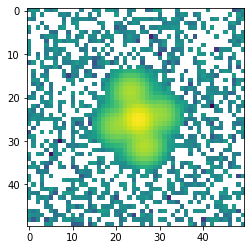

In [19]:
beta_ra,beta_dec = -1.18, -0.6
phi,q = -14.,0.55
x1,x2 = -1.17,-0.58
theta_e = 1.2


deltaPix = 0.2
numpix = 50
fwhm_psf = 0.8
exp_time = 1000
background_rms = 0.05

sistema1=sim_img(beta_ra,beta_dec,phi,q,x1,x2,theta_e,deltaPix,numpix,fwhm_psf,exp_time,background_rms)
plt.imshow(np.log10(sistema1))

In [15]:
header_dic = {'deltaPix': deltaPix,'numpix':numpix,'nameobj':'sistema1','exp_time':exp_time}
path = '/home/karina/Dropbox/Clase_lens/Clase6/'

save_simulation(header_dic,sistema1,path,'fig1')

saving image /home/karina/Dropbox/Clase_lens/Clase6/fig1.fits


## sistema 2

saving image /home/karina/Dropbox/Clase_lens/Clase6/fig2.fits


/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


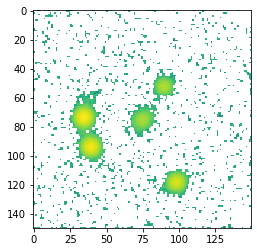

In [16]:
beta_ra,beta_dec = 0.35, -1.1
phi,q = -48.,0.5
x1,x2 = 0.381,-1.344
theta_e = 1.2
deltaPix = 0.03
numpix = 150
fwhm_psf = 0.2
exp_time = 100
background_rms = 0.05

sistema2=sim_img(beta_ra,beta_dec,phi,q,x1,x2,theta_e,deltaPix,numpix,fwhm_psf,exp_time,background_rms)
plt.imshow(np.log10(sistema2))

header_dic = {'deltaPix': deltaPix,'numpix':numpix,'nameobj':'sistema1','exp_time':exp_time}
path = '/home/karina/Dropbox/Clase_lens/Clase6/'
save_simulation(header_dic,sistema2,path,'fig2')

## sistema 3

saving image /home/karina/Dropbox/Clase_lens/Clase6/fig3.fits


/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


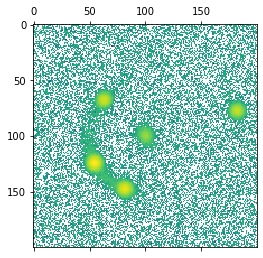

In [17]:
beta_ra,beta_dec = -0.95,1.6
phi,q = 73,0.5
x1,x2 = -1.44,1.71
theta_e = 1.9
deltaPix = 0.03
numpix = 200
fwhm_psf = 0.2
exp_time =100
background_rms = 0.05

sistema3=sim_img(beta_ra,beta_dec,phi,q,x1,x2,theta_e,deltaPix,numpix,fwhm_psf,exp_time,background_rms)
plt.matshow(np.log10(sistema3))

header_dic = {'deltaPix': deltaPix,'numpix':numpix,'nameobj':'sistema1','exp_time':exp_time}
path = '/home/karina/Dropbox/Clase_lens/Clase6/'
save_simulation(header_dic,sistema3,path,'fig3')

## sistema 4

saving image /home/karina/Dropbox/Clase_lens/Clase6/fig4.fits


/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


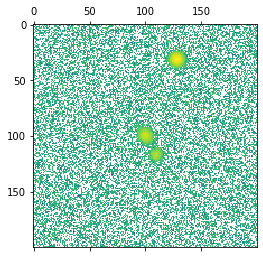

In [18]:
beta_ra,beta_dec = 0.3,0.9
phi,q = 45,0.35
x1,x2 = 0.31,1.6
theta_e = 1.5
deltaPix = 0.03
numpix = 200
fwhm_psf = 0.2
exp_time =100
background_rms = 0.05

sistema4=sim_img(beta_ra,beta_dec,phi,q,x1,x2,theta_e,deltaPix,numpix,fwhm_psf,exp_time,background_rms)
plt.matshow(np.log10(sistema4))

header_dic = {'deltaPix': deltaPix,'numpix':numpix,'nameobj':'sistema1','exp_time':exp_time}
path = '/home/karina/Dropbox/Clase_lens/Clase6/'
save_simulation(header_dic,sistema4,path,'fig4')